# 0. Environment Set up

In [113]:
## NEEDED PACKAGES:
# process data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import itertools

# visualize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

# model
import sklearn
import xgboost as xgb

# measure running time
import datetime
import timeit

# files path
import os
for dirname, _, filenames in os.walk('E:\DA_LEARNING\Projects\portfolio\spotify'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

E:\DA_LEARNING\Projects\portfolio\spotify\spotify.csv
E:\DA_LEARNING\Projects\portfolio\spotify\spotify.csv.zip
E:\DA_LEARNING\Projects\portfolio\spotify\stf-eda.ipynb
E:\DA_LEARNING\Projects\portfolio\spotify\stf-eda_predict.ipynb
E:\DA_LEARNING\Projects\portfolio\spotify\stf-eda_stats.ipynb


# 1. Data Preparation

In [114]:
df = pd.read_csv('E:\DA_LEARNING\Projects\portfolio\spotify\spotify.csv')

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [116]:
print("The dataset has", len(df),"rows and", len(df.columns), "columns.")

The dataset has 32833 rows and 23 columns.


In [117]:
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


**Dataset Overview**
- Each observation is a track, with its information, the albums including that track, the playlists with related information which contain that track, and tracks' audio features. 
- All 23 features can be divided into 2 main groups:
    * Identity columns: track_id, track_name, track_artist, track_album_id, track_album_name, track_album_release_date, all info about playlist, duration.
    * Columns describe music indicators of track: mode, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo
    * Column describe how the track popular: track_popularity. This column might be most important for some stakeholders (such as producers) know how much attractive do their tracks have on the platform, also being useful for analyst to know which factors might affect to this indicator.
- Reference: https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404


# 2. Pre-processing data
## 2.1. Duplicates Checking

In [118]:
len(df.drop_duplicates(subset=['track_id'])) == len(df)

False

There are some duplicated tracks. Next step is to check how many track duplicated and how to unify them as 1 row for each track.

In [119]:
duplicates = pd.DataFrame(df['track_id'].value_counts()).reset_index()
duplicates.columns = ['track_id', 'count']
track_dup = duplicates.loc[duplicates['count'] > 1]['track_id'].unique().tolist()   
print("There are", len(track_dup), "tracks are duplicated.")

There are 3166 tracks are duplicated.


Duplicated rows from same tracks appear because they are allocated in many different playlists. Next step, checking which attributes of same tracks depending on different playlists.

In [120]:
checked_cols = [col for col in df.columns if col != 'track_id']
track_grouped = df.groupby('track_id').agg(set).reset_index()
for col in checked_cols:
    track_grouped[col] = track_grouped[col].apply(lambda x: len(x))
    
track_grouped.set_index('track_id').stack()[track_grouped.set_index('track_id').stack() > 1].unstack()

,playlist_name,playlist_id,playlist_subgenre,playlist_genre
track_id,,,,
00Gu3RMpDW2vO9PjlMVFDL,2.0,2.0,2.0,NaN
00QyLmjxaSEE8qIZQjBXBj,3.0,3.0,3.0,3.0
00ReeHCY0FQUyuAUyPJdnk,2.0,2.0,2.0,NaN
00WIXhVVhswHuS6dlkScuw,2.0,2.0,2.0,2.0
00i0O74dXdaKKdCrqHnfXm,2.0,2.0,2.0,NaN
...,...,...,...,...
7ylkmI5exdKG5Myo7DuH2p,2.0,2.0,2.0,NaN
7zBkFHiWejDPxIimU8XpVw,2.0,2.0,2.0,2.0
7zFXmv6vqI4qOt4yGf3jYZ,2.0,2.0,2.0,NaN


Only attributes of playlist are affected. Strategy for the next processing:
* With playlist_name, playlist_genre, playlist_subgenre: these 3 columns can be used to extract more features base on its medium cardinality level.
* With playlist_id: Because of having not been focused yet in the current analysis, this column can be temporarily removed.

In [121]:
unique_tracks = df.groupby('track_id').agg(list).reset_index()[['track_id', 'playlist_name','playlist_subgenre', 'playlist_genre']]
df_1 = pd.merge(
    df.drop(['playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre'], axis = 1),
    unique_tracks,
    on = 'track_id', 
    how = 'left'
).drop_duplicates(subset=['track_id'])

len(df_1)

28356

## 2.2. Cleaning missing values

In [122]:
round(df_1.isnull().sum() / df_1.shape[0] * 100.00,2)

track_id                    0.00
track_name                  0.01
track_artist                0.01
track_popularity            0.00
track_album_id              0.00
track_album_name            0.01
track_album_release_date    0.00
danceability                0.00
energy                      0.00
key                         0.00
loudness                    0.00
mode                        0.00
speechiness                 0.00
acousticness                0.00
instrumentalness            0.00
liveness                    0.00
valence                     0.00
tempo                       0.00
duration_ms                 0.00
playlist_name               0.00
playlist_subgenre           0.00
playlist_genre              0.00
dtype: float64

The null percentage is very few, appear only in identity columns. Filling strategy: replace NULL values by "Unknown".

In [123]:
df_1['track_name'].fillna("Unknown", inplace=True)
df_1['track_artist'].fillna("Unknown", inplace=True)
df_1['track_album_name'].fillna("Unknown", inplace=True)

Because the df dataset is still used for analysis related to playlist, so it should be cleaned as df_1

In [124]:
df['track_name'].fillna("Unknown", inplace=True)
df['track_artist'].fillna("Unknown", inplace=True)
df['track_album_name'].fillna("Unknown", inplace=True)

In [125]:
# change measurement of duration, from ms to s
df_1['duration_s'] = df_1['duration_ms']/1000
df['duration_s'] = df['duration_ms']/1000

# 3. EDA

Find out how values of each single variable look like. All variables could be categorized into groups below:

In [126]:
numeric_cols = ['track_popularity','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']
categorical_cols = ['track_name', 'track_artist',  'track_album_id', 'track_album_name'] # not count track_id as identity col
array_cols = [ 'playlist_name', 'playlist_subgenre', 'playlist_genre']
datetime_cols = ['track_album_release_date']

#### Question: How is general distribution of track popularity?

count    28356.000000
mean        39.329771
std         23.702376
min          0.000000
25%         21.000000
50%         42.000000
75%         58.000000
max        100.000000
Name: track_popularity, dtype: float64


<Axes: xlabel='track_popularity', ylabel='Density'>

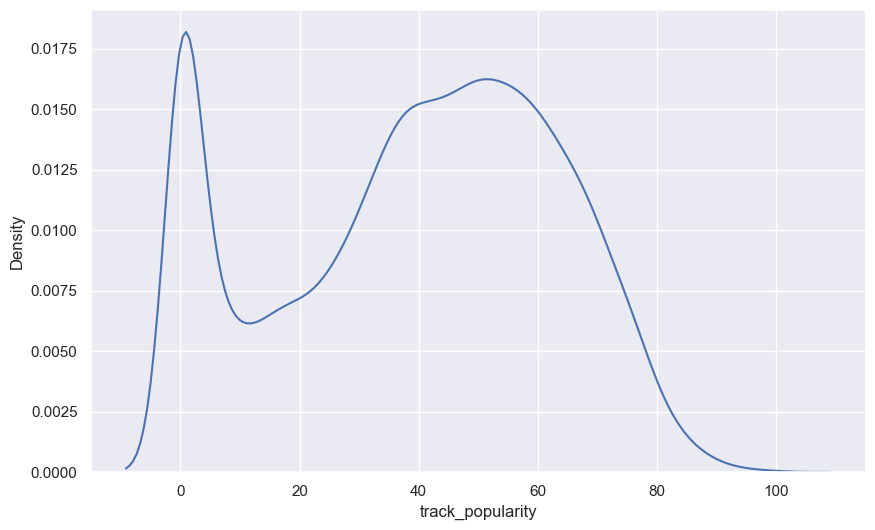

In [127]:
print(df_1['track_popularity'].describe())
sns.kdeplot(data = df_1, x = 'track_popularity')

* There are 2 peaks of popularity score. Most popular score is around 40-60, and many tracks got 0 score.
* The distance between mean and median is very few (3 scores) so both of them can represent for the whole dataset without bring any different insights. In the next analysis, mean is used to analyze track popularity statistically.

In [128]:
# How many tracks got 0 score
print("Percentage of tracks got 0 score is:", str(round((df_1['track_popularity'] == 0).sum()/len(df_1)*100)) + "%")

Percentage of tracks got 0 score is: 9%


The percentage of 0-score tracks is not much so it temporarily does not need detecting deeper.

#### Question: When were tracks released on Spotify?

Text(0.5, 1.0, 'Release time of tracks')

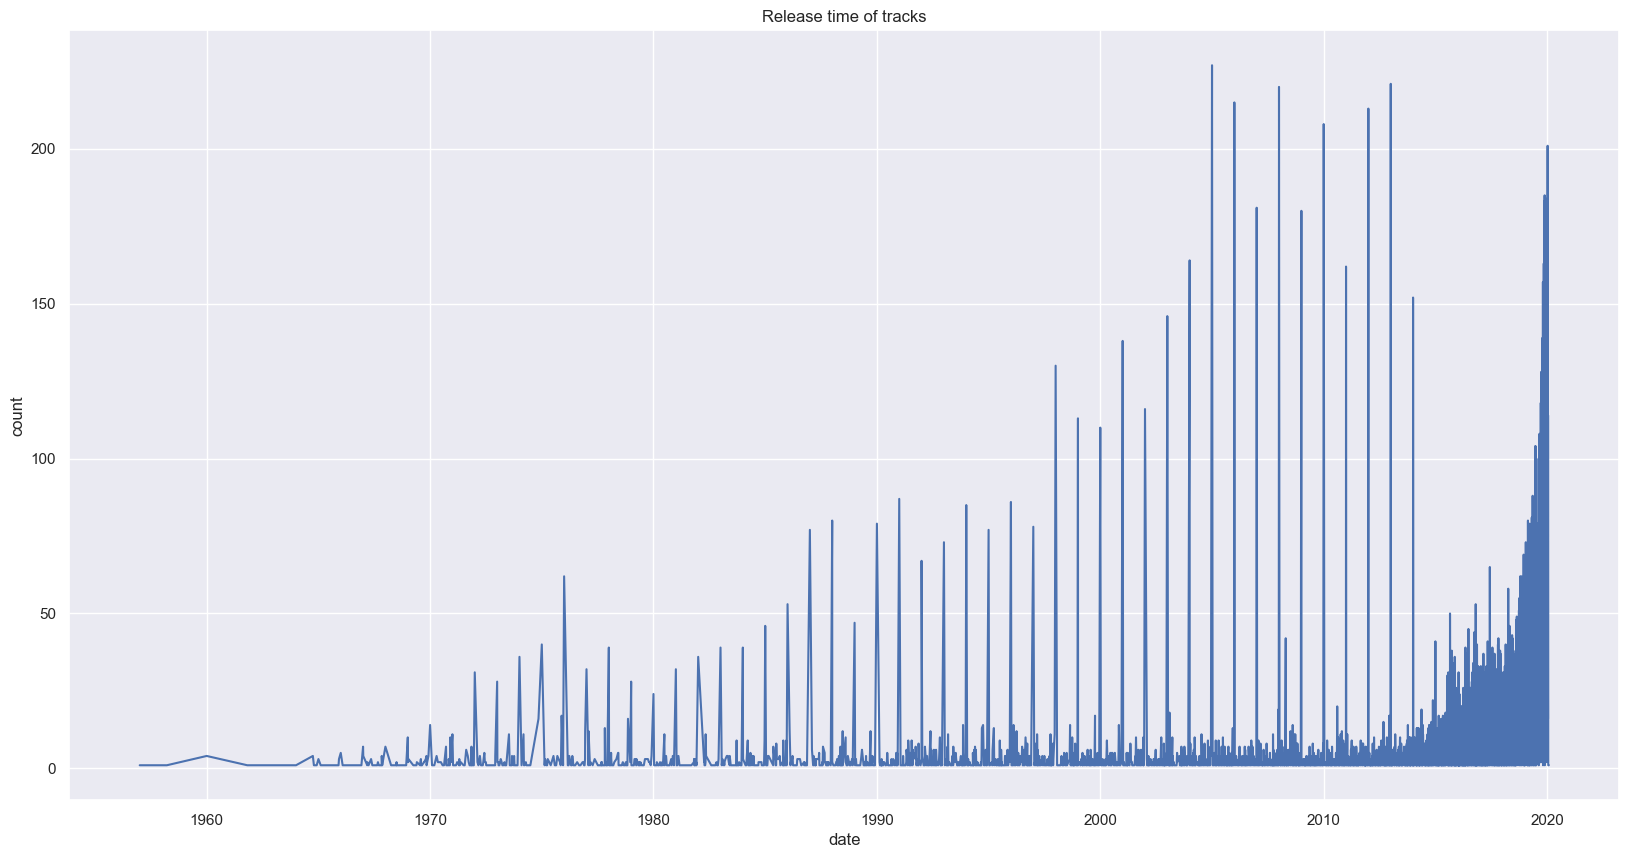

In [129]:
df_date = df_1.copy()
df_date['track_album_release_date'] = pd.to_datetime(df_date['track_album_release_date'], format="ISO8601")
date_count = pd.DataFrame(df_date['track_album_release_date'].value_counts()).reset_index()
date_count.columns = ['date', 'count']
date_count = date_count.sort_values(by = 'date', ascending=True)

fig, ax = plt.subplots( figsize=(20,10))
ax = sns.lineplot(data = date_count, x = 'date', y='count')
ax.set_title("Release time of tracks")

The timeline by single date is very dense and difficult to look for insights. Trying to replace by every month.

Text(0.5, 1.0, 'Release time of tracks')

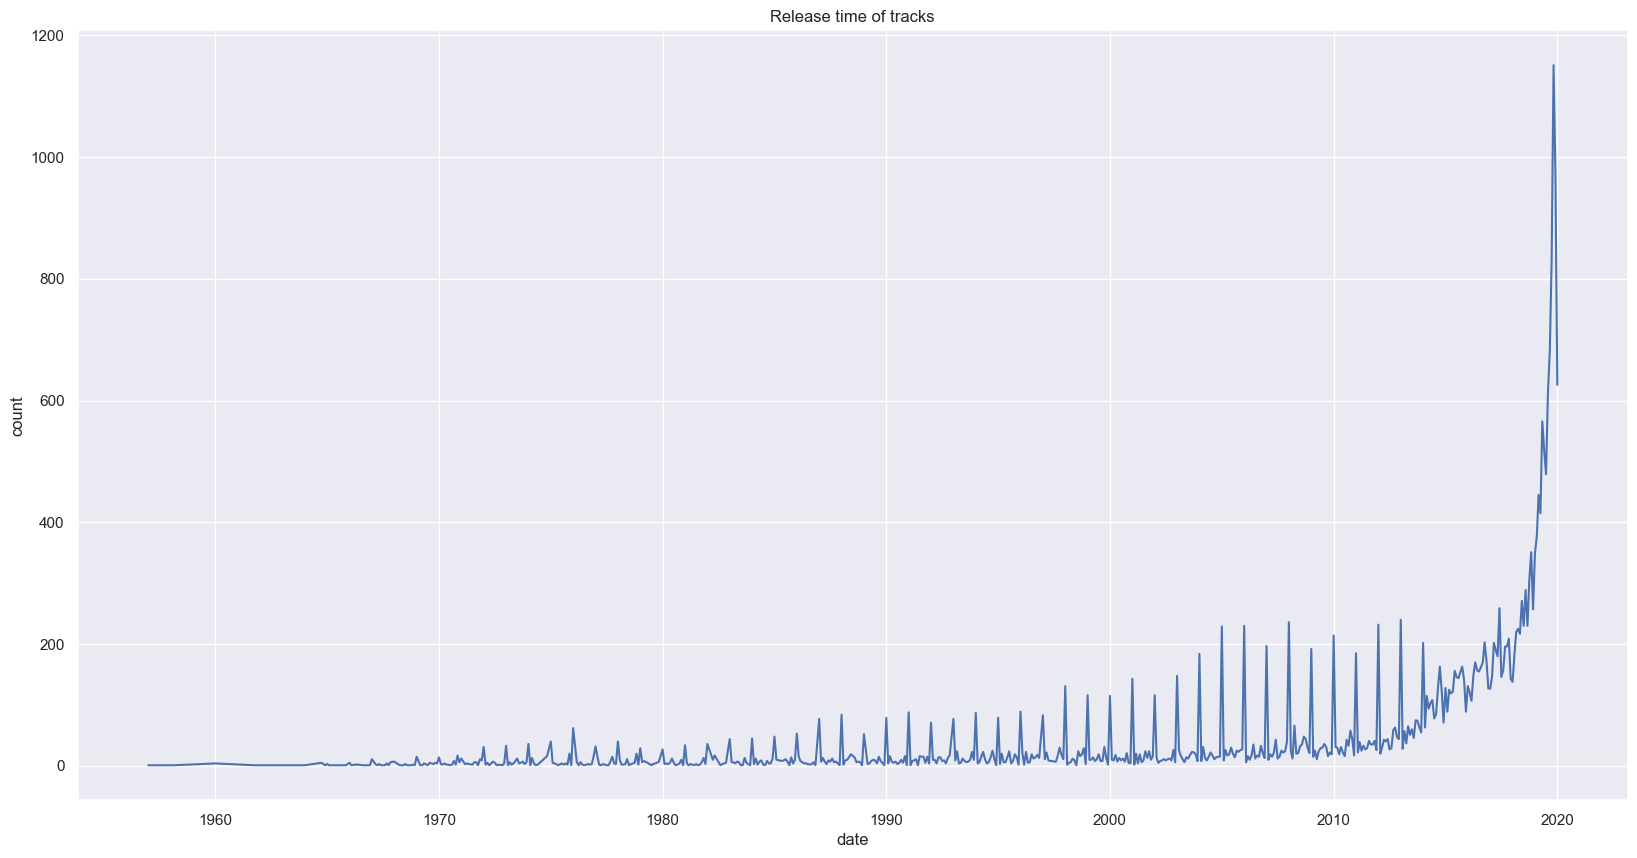

In [130]:
# Create new column with only year and month
df_date['track_album_release_year'] = df_date['track_album_release_date'].apply(lambda x: x.year)
df_date['track_album_release_month'] = df_date['track_album_release_date'].apply(lambda x: x.month)
df_date['track_album_release_YearMonth'] = df_date.apply(lambda x: str(x['track_album_release_year']) + "-" + str(x['track_album_release_month']), axis = 1)
df_date['track_album_release_YearMonth'] = pd.to_datetime(df_date['track_album_release_YearMonth'], format = "%Y-%m")


date_count = pd.DataFrame(df_date['track_album_release_YearMonth'].value_counts()).reset_index()
date_count.columns = ['date', 'count']
date_count = date_count.sort_values(by = 'date', ascending=True)

fig, ax = plt.subplots( figsize=(20,10))
ax = sns.lineplot(data = date_count, x = 'date', y='count')
ax.set_title("Release time of tracks")

* A large of tracks is on stage at Spotify around 2013 up to now. However, there are also many tracks come from previous decades (1960s).  
* There are some strange moments within a year that the number of tracks suddenly released a lot. There are should be checked why.

In [131]:
df_date.loc[df_date['track_album_release_YearMonth'] <= "2010"]['track_album_release_YearMonth'].value_counts().head(15)

track_album_release_YearMonth
2008-01-01    236
2006-01-01    230
2005-01-01    229
2010-01-01    214
2007-01-01    197
2009-01-01    192
2004-01-01    184
2003-01-01    148
2001-01-01    143
1998-01-01    131
1999-01-01    116
2002-01-01    116
2000-01-01    115
1996-01-01     89
1991-01-01     88
Name: count, dtype: int64

* Those were at the beginning of year. That might be a consequence of transforming data type, as those values originally were only year. 

#### Question: Are tracks popularity related to its year of release?

<Axes: xlabel='track_album_release_year', ylabel='track_popularity'>

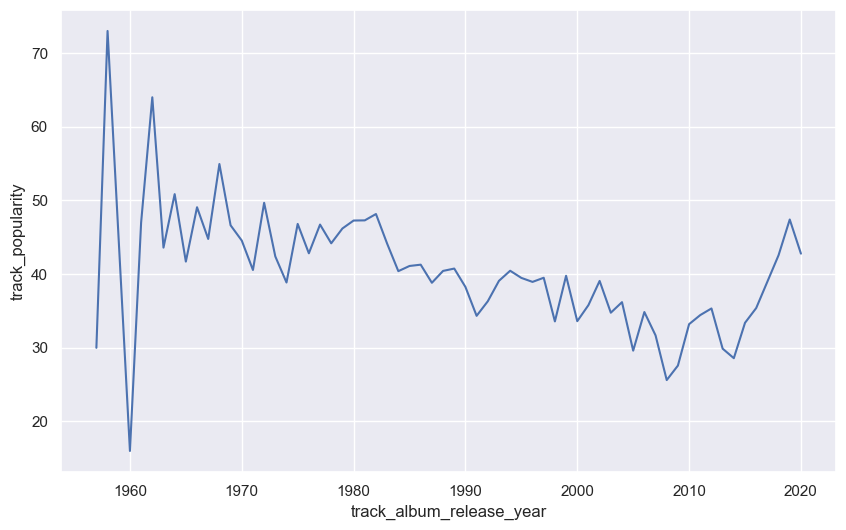

In [132]:
sns.set(rc={'figure.figsize':(10,6)})
sns.lineplot(
    data = df_date.groupby('track_album_release_year').agg({'track_popularity': 'mean'}).sort_values(by = 'track_album_release_year', ascending=True).reset_index(),
    x = 'track_album_release_year',
    y = 'track_popularity'
)

Track scores were not stable at around 1960s, then overally decrease through years. It has started grown up after 2010s.

### Check cardinality level of categorical variables

In [133]:
# Check Cardinality Level
cardinality = pd.DataFrame(columns = ['column_name', 'unique_values'])
for col in categorical_cols:
    unique_values = len(df_1[col].unique())
    cardinality.loc[len(cardinality)] = [col, unique_values]

for col in array_cols:
    unique_values = len(np.unique(list(itertools.chain(*df_1[col]))))
    cardinality.loc[len(cardinality)] = [col, unique_values]

cardinality.sort_values(by = 'unique_values', ascending=False)

,column_name,unique_values
0,track_name,23450
2,track_album_id,22545
3,track_album_name,19744
1,track_artist,10693
4,playlist_name,449
5,playlist_subgenre,24
6,playlist_genre,6


* track_name, track_album_id: Unique values are nearly equal to rows number of dataset, should treat it as identity values.
* track_artist, track_album_name: High cardinality level, good to skim through a sample of top values get most count of data and how their popularity scores are.
* playlist_name, playlist_genre, playlist_subgenre: Cardinality is medium and low, good to look at some descriptive analysis.

#### Question: What is top 10 of track album and artists in terms of tracks amount?

In [134]:
# Top 10 album names have most tracks on Spotify
df_1['track_album_name'].value_counts().head(10)

track_album_name
Greatest Hits                      135
Ultimate Freestyle Mega Mix         42
Gold                                34
Rock & Rios (Remastered)            29
Asian Dreamer                       20
Trip Stories                        20
Forever                             18
Malibu                              18
Los Grandes Éxitos En Español       17
Confessions of a Dangerous Mind     16
Name: count, dtype: int64

In [135]:
# Top 10 artists release most tracks on Spotify platform
df_1['track_artist'].value_counts().head(10)

track_artist
Queen                        130
Martin Garrix                 87
Don Omar                      84
David Guetta                  81
Dimitri Vegas & Like Mike     68
Hardwell                      68
Drake                         68
The Chainsmokers              66
Logic                         65
Guns N' Roses                 63
Name: count, dtype: int64

#### Question: What is top 10 of tracks, its album and artists in terms of popularity score (averagely)?

In [136]:
# Tracks
df_1.sort_values(by = 'track_popularity', ascending=False)[['track_name', 'track_artist', 'track_popularity']].head(10)

,track_name,track_artist,track_popularity
1551,Dance Monkey,Tones and I,100
20092,ROXANNE,Arizona Zervas,99
711,Memories,Maroon 5,98
687,Tusa,KAROL G,98
716,Blinding Lights,The Weeknd,98
1301,Circles,Post Malone,98
5508,The Box,Roddy Ricch,98
689,everything i wanted,Billie Eilish,97
1302,Don't Start Now,Dua Lipa,97
3155,Falling,Trevor Daniel,97


In [137]:
# Track's albums
df_1.groupby(['track_album_name', 'track_artist']).agg({'track_popularity': 'mean'}).reset_index().sort_values(by = 'track_popularity', ascending=False).head(10)

,track_album_name,track_artist,track_popularity
4337,Dance Monkey (Stripped Back) / Dance Monkey,Tones and I,100.0
19597,Tusa,KAROL G,98.0
2433,Blinding Lights,The Weeknd,98.0
11615,Memories,Maroon 5,98.0
6042,Falling,Trevor Daniel,97.0
21529,everything i wanted,Billie Eilish,97.0
5027,Don't Start Now,Dua Lipa,97.0
21393,Yummy,Justin Bieber,95.0
21563,hot girl bummer,blackbear,94.0
15081,Ride It,Regard,94.0


In [138]:
# Artists
df_1.groupby('track_artist').agg({'track_popularity': 'mean'}).reset_index().sort_values(by = 'track_popularity', ascending=False).head(10)

,track_artist,track_popularity
9735,Trevor Daniel,97.000000
10243,Y2K,91.000000
2601,Don Toliver,87.500000
5040,Kina,85.500000
4196,JACKBOYS,84.333333
2216,Dadá Boladão,84.000000
2209,DaBaby,83.666667
7959,Roddy Ricch,83.428571
4122,Internet Money,83.000000
845,Baby Keem,83.000000


#### Question: How many tracks on a playlist averagely? How average popularity scores of playlists?

count    449.000000
mean      73.124722
std       36.151437
min        1.000000
25%       49.000000
50%       77.000000
75%       97.000000
max      308.000000
Name: count, dtype: float64


<Axes: >

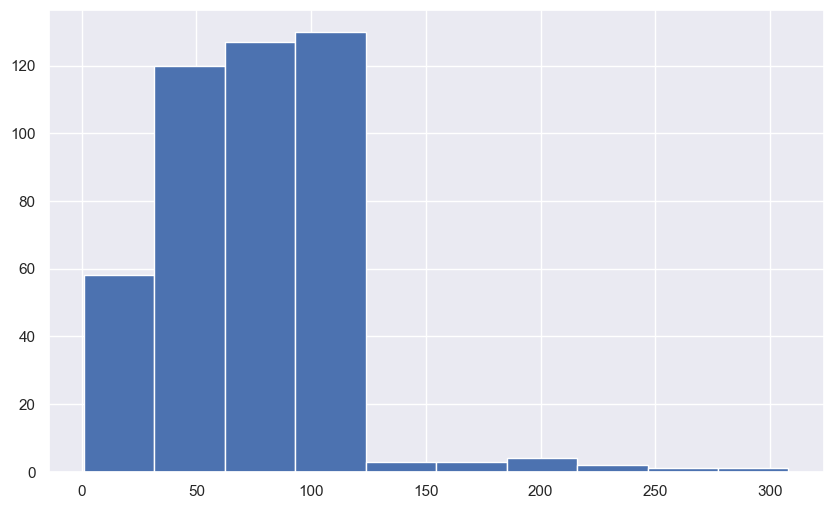

In [139]:
playlist_df = df[['playlist_name', 'playlist_genre', 'playlist_subgenre', 'track_popularity']].reset_index(drop=True)
print(playlist_df['playlist_name'].value_counts().describe())
playlist_df['playlist_name'].value_counts().hist()

* A playlist collects averagely 73 songs, which the mostly popular range is from 49 to 97 songs. Very few playlists contains more than 100 songs when there is a big gap between the bins split line at 100.

<Axes: xlabel="('track_popularity', 'mean')", ylabel='Count'>

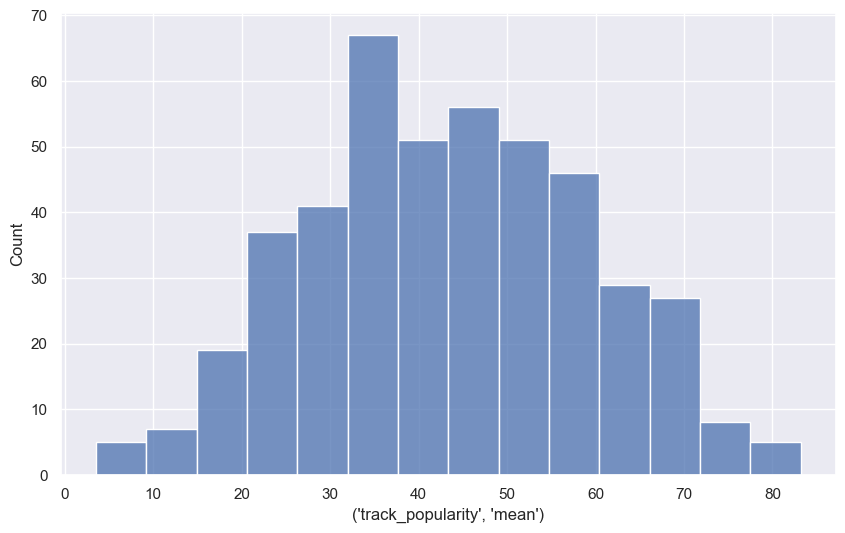

In [140]:
# Abut popularity score of playlists
playlist_1 = playlist_df.groupby('playlist_name').agg({'track_popularity': ['count', 'mean']}).reset_index()
sns.set(rc={'figure.figsize':(10,6)})
sns.histplot(data = playlist_1, x = ('track_popularity',  'mean'))

The distribution of track popularity means representing for playlists is closely symmetric, with peak is around 35 scores. 

In [141]:
playlist_1[[('track_popularity', 'count'),
            ('track_popularity',  'mean')]].corr()

track_popularity          
                                  count      mean
track_popularity count         1.000000 -0.118889
                 mean         -0.118889  1.000000

No correlation between playlists volume and its popularity index.

#### Question: How are Genres and Sub Genres in terms of number of playlist and tracks belonging and genre popularity index generally?

In [142]:
# How are distributions of Genre and Sub Genre of Playlists?
playlist_2 = playlist_df.groupby('playlist_genre').agg({'playlist_name': 'nunique', 'track_popularity': ['count', 'mean']}).reset_index()
playlist_2.columns = ['playlist_genre', 'playlist_count', 'track_count', 'track_popularity_mean']
playlist_2.sort_values(by = 'playlist_count', ascending=False)

,playlist_genre,playlist_count,track_count,track_popularity_mean
0,edm,78,6043,34.833526
1,latin,78,5155,47.026576
4,rap,77,5746,43.215454
3,r&b,76,5431,41.223532
2,pop,73,5507,47.744870
5,rock,72,4951,41.728338


* EDM has most number of playlists and tracks as well, but the popularity score is lowest.
* Latin and Pop get highest popularity index.

In [143]:
# Sub Genre
playlist_3 = playlist_df.groupby(['playlist_genre', 'playlist_subgenre']).agg({'playlist_name': 'nunique', 'track_popularity': ['count', 'mean']}).reset_index()
playlist_3.columns = ['playlist_genre',  'playlist_subgenre', 'playlist_count', 'track_count', 'track_popularity_mean']
playlist_3.sort_values(by = 'track_popularity_mean', ascending=False)

,playlist_genre,playlist_subgenre,playlist_count,track_count,track_popularity_mean
11,pop,post-teen pop,17,1129,56.825509
23,rock,permanent wave,15,1105,54.000905
12,r&b,hip pop,20,1256,53.844745
17,rap,hip hop,20,1322,53.773071
6,latin,reggaeton,20,949,52.869336
8,pop,dance pop,19,1298,52.079353
5,latin,latin pop,20,1262,51.099842
15,r&b,urban contemporary,17,1405,50.523843
19,rap,trap,20,1291,50.308288
2,edm,pop edm,20,1517,45.686223


* Subgenres having top highest popularity score mostly contain pop as a part.

### Sound Indicators Analysis

In [144]:
# Descriptive metrics
sound_index_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_s']
pop_index = ['track_popularity']
sound_ind_desc_stats = df_1[sound_index_cols].describe().transpose()
sound_ind_desc_stats

# Calculate Skewness level
"""
Skewness: 
- Formula: 3*(median - mean)/std

- Grouping:
+ A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. 
+ A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. 
+ A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.
"""

sound_ind_desc_stats['skewness'] = sound_ind_desc_stats.apply(lambda x: round(3*(x['50%'] - x['mean'])/x['std'],2), axis = 1)

def skewness_evaluate(score):
    if score < -1:
        return "strongly right skew"
    elif (score >= -1) & (score < -0.5):
        return "moderately right skew"
    elif (score >= -0.5) & (score <= 0.5):
        return "symmetric"
    elif (score > 0.5) & (score <= 1):
        return "moderately left skew"
    elif (score > 1):
        return "strongly left skew"
    
sound_ind_desc_stats['skewness_eval'] = sound_ind_desc_stats['skewness'].apply(lambda x: skewness_evaluate(x))
sound_ind_desc_stats

,count,mean,std,min,25%,50%,75%,max,skewness,skewness_eval
danceability,28356.0,0.653372,0.145785,0.000000,0.561000,0.670000,0.76000,0.983,0.34,symmetric
energy,28356.0,0.698388,0.183503,0.000175,0.579000,0.722000,0.84300,1.000,0.39,symmetric
key,28356.0,5.368000,3.613904,0.000000,2.000000,6.000000,9.00000,11.000,0.52,moderately left skew
loudness,28356.0,-6.817696,3.036243,-46.448000,-8.309250,-6.261000,-4.70900,1.275,0.55,moderately left skew
mode,28356.0,0.565489,0.495701,0.000000,0.000000,1.000000,1.00000,1.000,2.63,strongly left skew
speechiness,28356.0,0.107954,0.102556,0.000000,0.041000,0.062600,0.13300,0.918,-1.33,strongly right skew
acousticness,28356.0,0.177176,0.222803,0.000000,0.014375,0.079700,0.26000,0.994,-1.31,strongly right skew
instrumentalness,28356.0,0.091117,0.232548,0.000000,0.000000,0.000021,0.00657,0.994,-1.18,strongly right skew
liveness,28356.0,0.190958,0.155894,0.000000,0.092600,0.127000,0.24900,0.996,-1.23,strongly right skew
valence,28356.0,0.510387,0.234340,0.000000,0.329000,0.512000,0.69500,0.991,0.02,symmetric


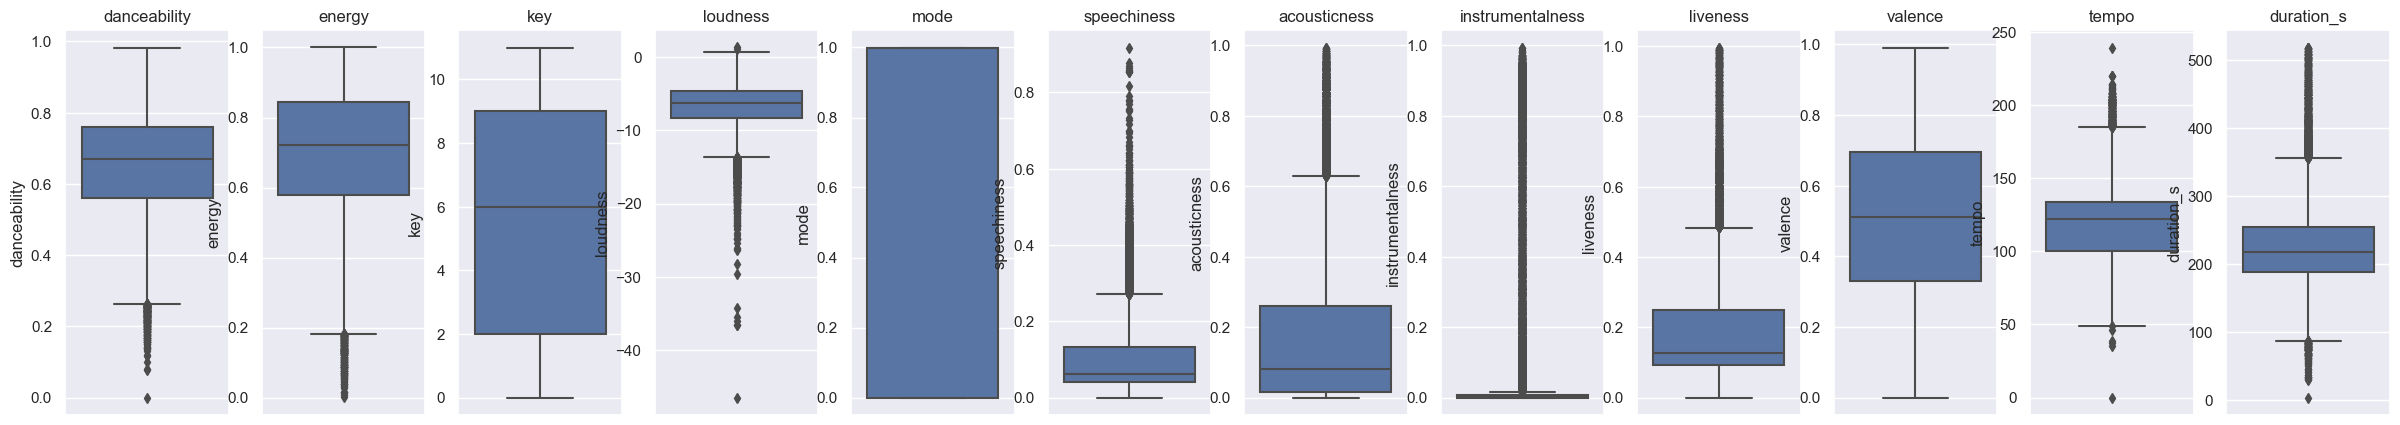

In [145]:
# Botplot of distribution
fig, ax = plt.subplots(1, len(sound_index_cols), figsize = (30, 5))
i = 0
for col in sound_index_cols:
    sns.boxplot(data = df_1, y = col, ax = ax[i])
    ax[i].set_title(col, loc= 'center')
    i += 1

In [146]:
df_1['mode'].value_counts()

mode
1    16035
0    12321
Name: count, dtype: int64

* Valence has the most symmetrical form, following is tempo.
* Strong skewnesses comes from **speechiness, acousticness, liveness, instrumentalness** respectively. All of these skewing form are right.
* Mode is binary data with unique values are 0 and 1 --> Not be considered as a continuous variable.


### Regression Analysis among Sound Index Variables and Track Popularity

In [147]:
sound_index_cols = [col for col in sound_index_cols if col != 'mode']
sound_index_cols

['danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_s']

<Axes: >

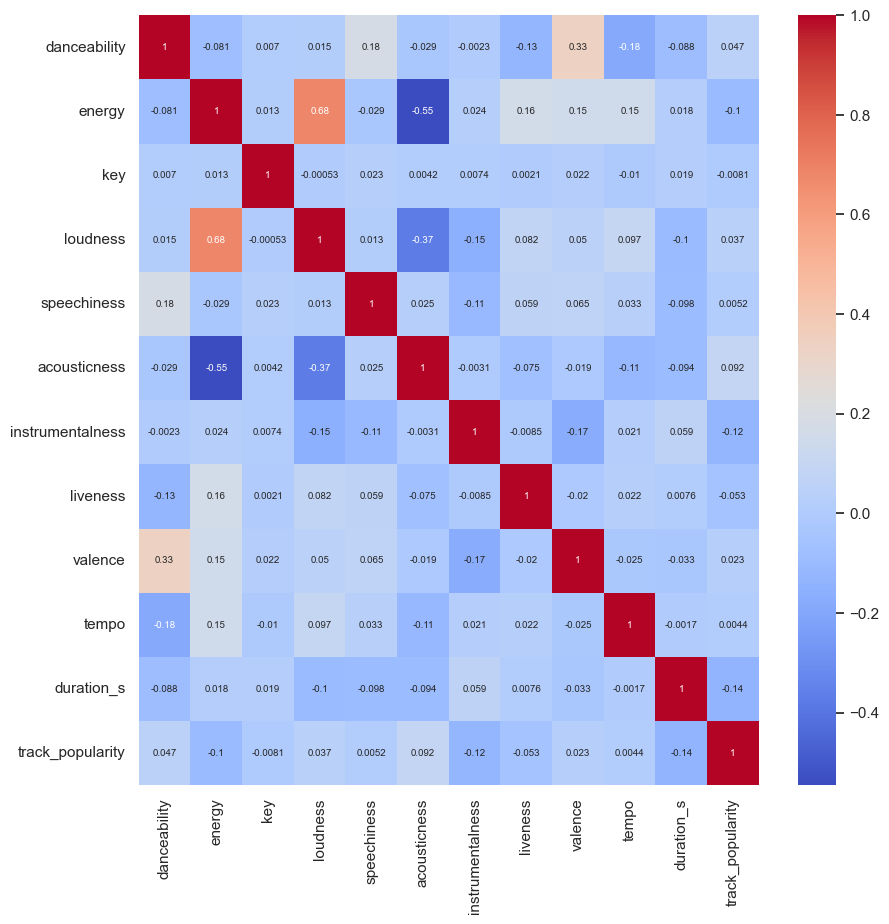

In [148]:
# Evaluate Correlation Coefficients
fig, ax = plt.subplots(1,1,figsize=(10, 10))
sns.heatmap(df_1[sound_index_cols + pop_index].corr(method='pearson'), 
            xticklabels=df_1[sound_index_cols + pop_index].corr().columns.values,
            yticklabels=df_1[sound_index_cols + pop_index].corr().columns.values, 
            annot = True,
            cmap = 'coolwarm',
            annot_kws={'size': 7}
           )

In [149]:
# Correlation score table
numeric_corr = df_1[sound_index_cols + pop_index].corr().unstack().reset_index()
numeric_corr.columns = ['var1', 'var2', 'corr_coef'] 
numeric_corr['vars'] = numeric_corr.apply(lambda x: sorted([x['var1'], x['var2']]), axis = 1)
numeric_corr = numeric_corr.loc[numeric_corr['corr_coef'] != 1].drop_duplicates(subset='vars')
numeric_corr['corr_coef_abs'] = numeric_corr['corr_coef'].apply(lambda x: abs(x))
numeric_corr['corr_type'] = numeric_corr['corr_coef'].apply(lambda x: 'positive' if x > 0 else 'negative')
numeric_corr = numeric_corr.sort_values(by = 'corr_coef_abs', ascending=False)
numeric_corr.loc[numeric_corr['corr_coef_abs'] >= 0.3]

,var1,var2,corr_coef,vars,corr_coef_abs,corr_type
15,energy,loudness,0.682138,"[energy, loudness]",0.682138,positive
17,energy,acousticness,-0.545886,"[acousticness, energy]",0.545886,negative
41,loudness,acousticness,-0.371602,"[acousticness, loudness]",0.371602,negative
8,danceability,valence,0.333729,"[danceability, valence]",0.333729,positive


Strong Correlation (|r| >= 0.5):
- Energy vs. Loudness, positively
- Energy vs. Acousticness, negatively

Moderate Correlation (|r| < 0.5):
- Loudness vs. Acousticness, negatively
- Valence vs. danceability, positively

None of features is strong correlation with track_popularity. The highest corr among them is from instrumentalness, duration and energy (all negative).

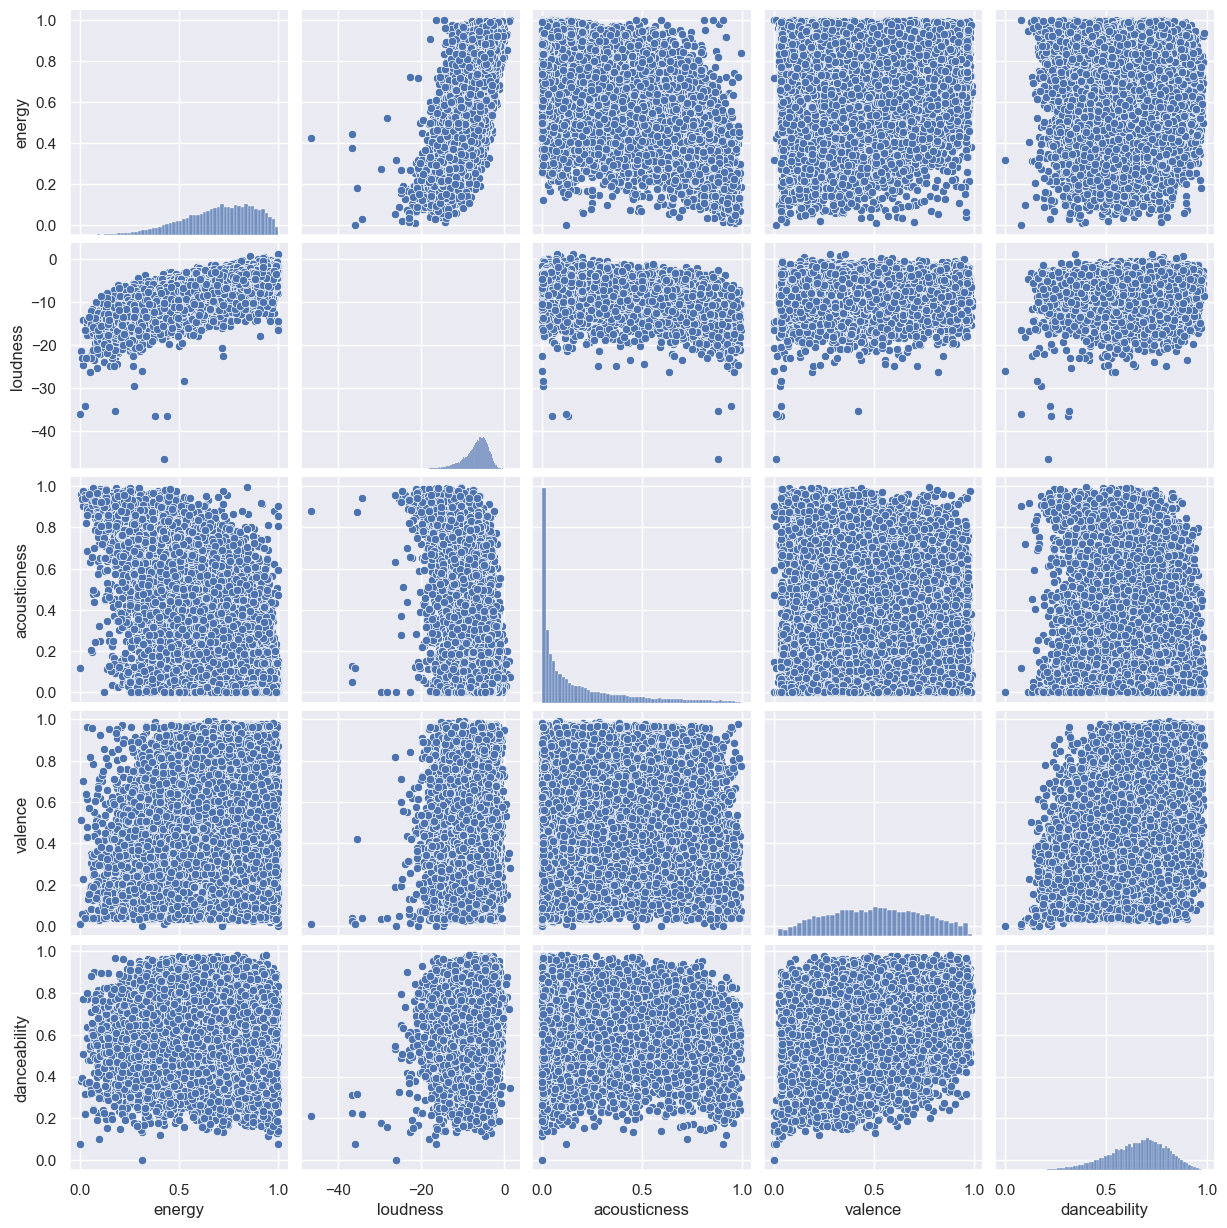

In [150]:
# Pairplot for correlated variables
corr_vars = ['energy', 'loudness', 'acousticness', 'valence', 'danceability']
sns.pairplot(data = df_1[corr_vars])

### Distribution of sound indocators by categorical variables of tracks, albums & playlist

#### With Genres

In [151]:
df.pivot_table(index = 'playlist_genre', values = sound_index_cols, aggfunc='mean')

,acousticness,danceability,duration_s,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence
playlist_genre,,,,,,,,,,,
edm,0.081504,0.655041,222.540858,0.802476,0.218578,5.352143,0.211859,-5.427445,0.086695,125.768024,0.400656
latin,0.210920,0.713287,216.863447,0.708312,0.044447,5.483996,0.180626,-6.264455,0.102653,118.622354,0.605510
pop,0.170794,0.639302,217.768104,0.701028,0.059876,5.318867,0.176833,-6.315328,0.073991,120.743178,0.503521
r&b,0.259904,0.670179,237.599490,0.590934,0.028920,5.400479,0.175268,-7.864848,0.116792,114.222156,0.531231
rap,0.192479,0.718353,214.163889,0.650708,0.075997,5.470936,0.191654,-7.042269,0.197506,120.654908,0.505090
rock,0.145189,0.520548,248.576500,0.732813,0.062417,5.209049,0.203135,-7.588895,0.057696,124.988786,0.537352


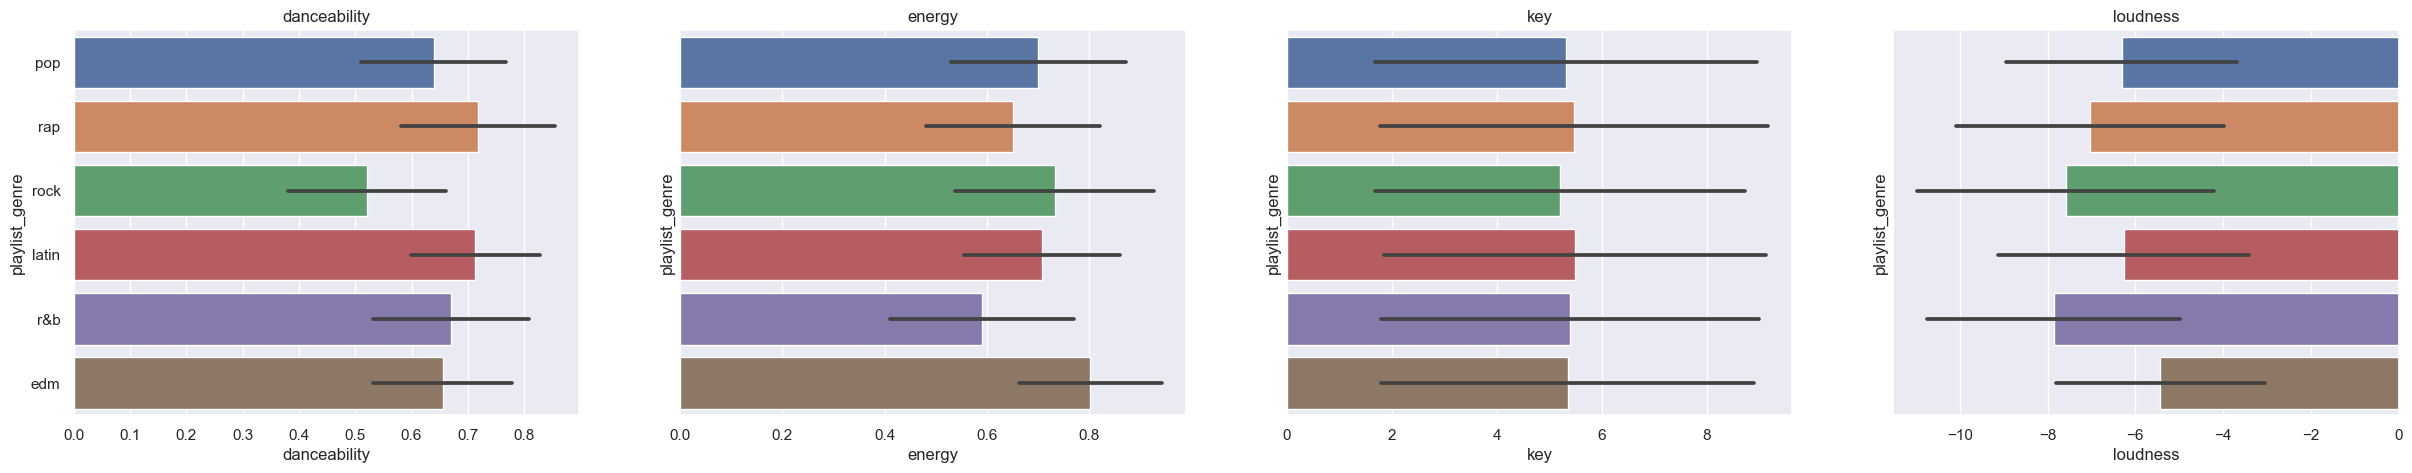

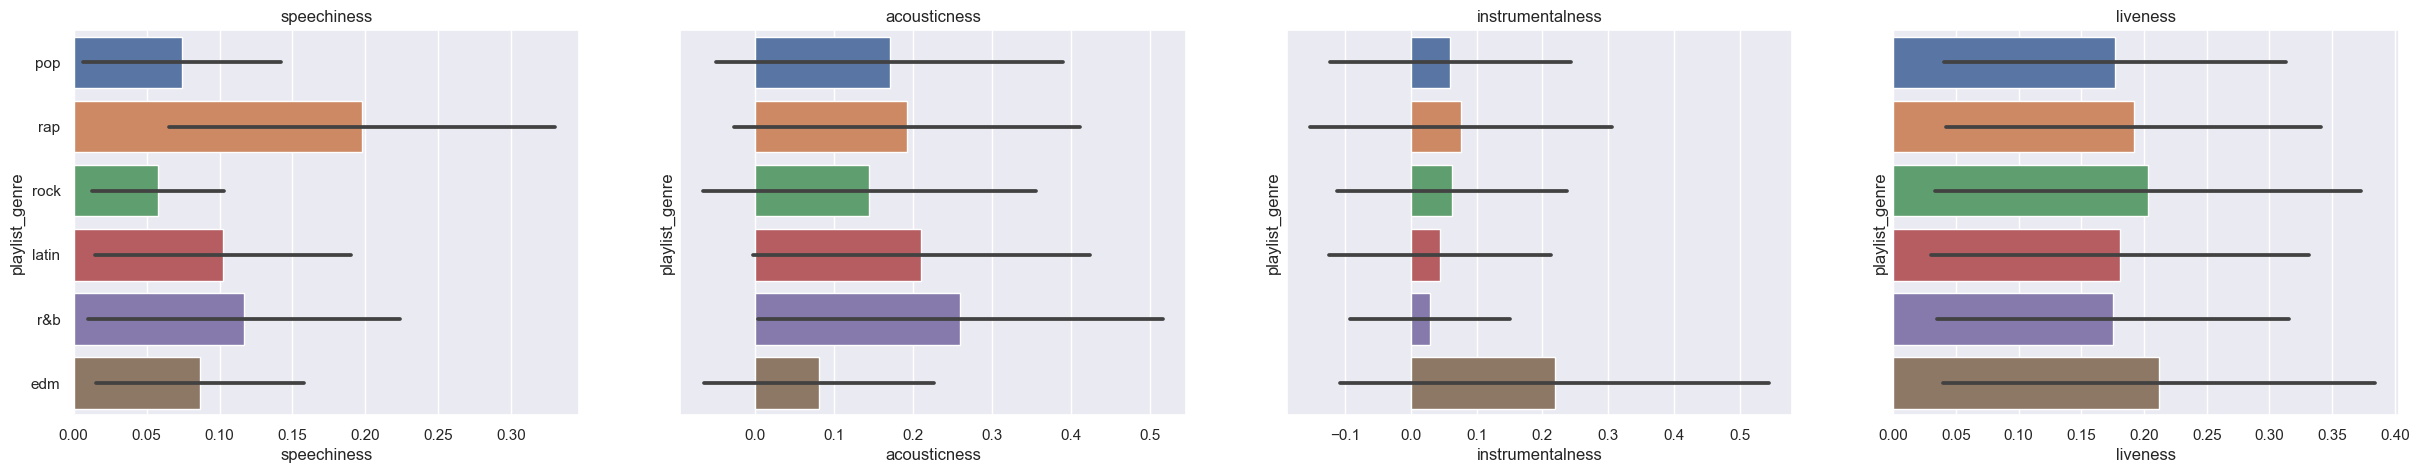

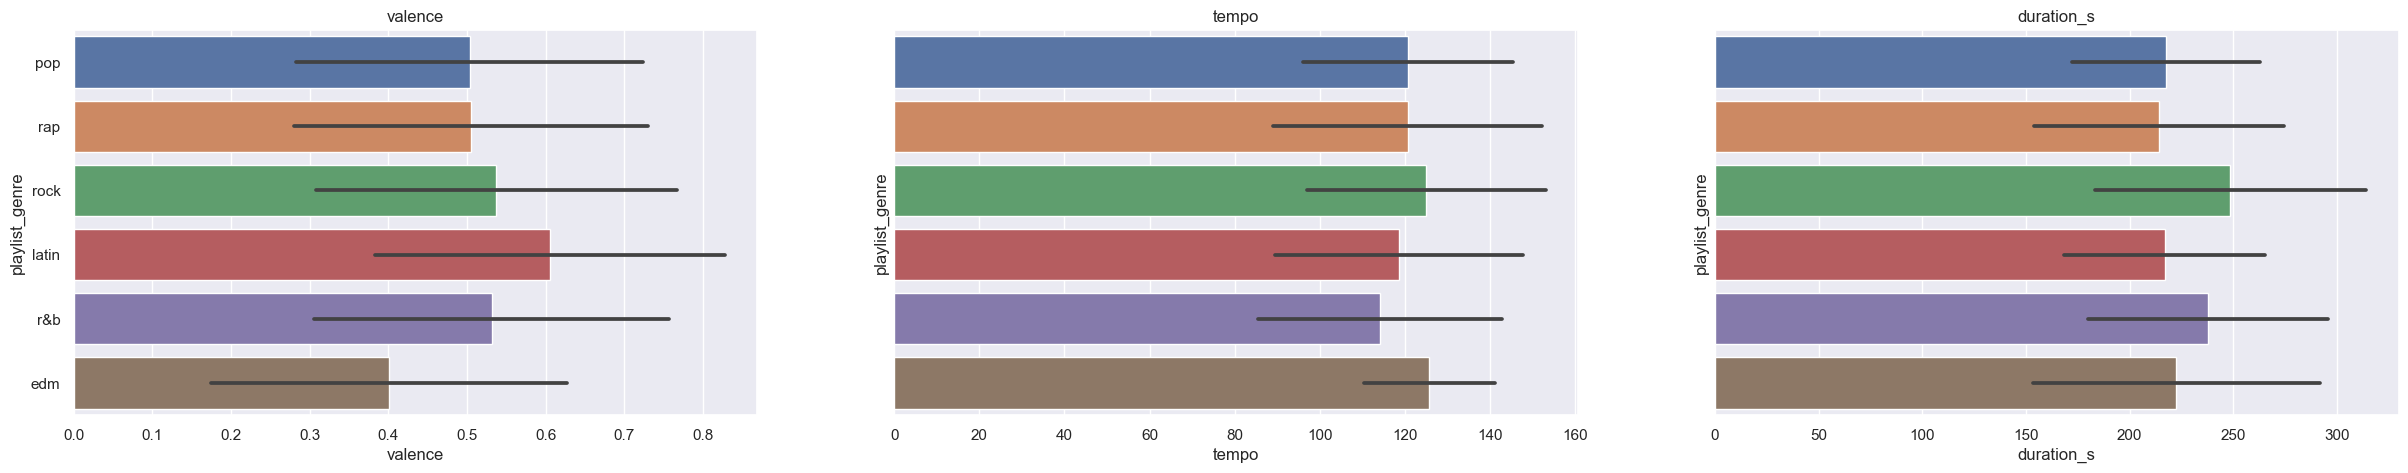

In [153]:
# Part 1
fig, ax = plt.subplots(1, len(sound_index_cols[0:4]), figsize=(30,5), sharey=True)
i = 0
for col in sound_index_cols[0:4]:
    sns.barplot(data = df, y = 'playlist_genre', x = col, errorbar='sd', ax = ax[i])
    ax[i].set_title(col)
    i += 1

# Part 2
fig, ax = plt.subplots(1, len(sound_index_cols[4:8]), figsize=(30,5), sharey=True)
i = 0
for col in sound_index_cols[4:8]:
    sns.barplot(data = df, y = 'playlist_genre', x = col, errorbar='sd', ax = ax[i])
    ax[i].set_title(col)
    i += 1

# Part 3
fig, ax = plt.subplots(1, len(sound_index_cols[8:]), figsize=(30,5), sharey=True)
i = 0
for col in sound_index_cols[8:]:
    sns.barplot(data = df, y = 'playlist_genre', x = col, errorbar='sd', ax = ax[i])
    ax[i].set_title(col)
    i += 1

* Rap songs lead to have fastest speech, while rock seems the lowest.  
* Danceability of rock is significantly lower than rest of genres.
* Energy of R&B is as not strong as other genres.
* Songs belonging EDM got mostly low acousticness and valence scores, but higher instrumentalness averagely.
* About track duration, rock songs have quite tendency to be longest among genre, with around 20s extended in terms of average, compare to other genres.

#### With Subgenres

In [154]:
subgenre_pivot_mean = df.pivot_table(index = ['playlist_genre', 'playlist_subgenre'], values = (sound_index_cols + pop_index), aggfunc='mean').reset_index()
subgenre_pivot_median = df.pivot_table(index = ['playlist_genre', 'playlist_subgenre'], values = (sound_index_cols + pop_index), aggfunc='median').reset_index()

In [155]:
subgenre_pivot_mean[sound_index_cols + pop_index].corr()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,track_popularity
danceability,1.000000,-0.230004,0.625331,0.194578,0.626521,0.224302,-0.013289,-0.372895,0.223308,-0.420255,-0.379187,0.096341
energy,-0.230004,1.000000,-0.063739,0.747326,-0.335360,-0.897304,0.393750,0.616926,-0.304796,0.700513,0.043171,-0.291801
key,0.625331,-0.063739,1.000000,0.065160,0.524735,-0.005827,-0.108399,0.030086,0.218687,-0.412765,-0.049525,-0.304441
loudness,0.194578,0.747326,0.065160,1.000000,-0.007736,-0.573252,0.210624,0.284445,-0.341698,0.495701,-0.441048,0.083519
speechiness,0.626521,-0.335360,0.524735,-0.007736,1.000000,0.205593,-0.113704,-0.030423,0.015134,-0.315835,-0.307894,0.003511
acousticness,0.224302,-0.897304,-0.005827,-0.573252,0.205593,1.000000,-0.337437,-0.643113,0.303997,-0.611780,-0.275058,0.473961
instrumentalness,-0.013289,0.393750,-0.108399,0.210624,-0.113704,-0.337437,1.000000,0.353373,-0.647934,0.418442,-0.183344,-0.329715
liveness,-0.372895,0.616926,0.030086,0.284445,-0.030423,-0.643113,0.353373,1.000000,-0.433022,0.451042,0.219048,-0.552669
valence,0.223308,-0.304796,0.218687,-0.341698,0.015134,0.303997,-0.647934,-0.433022,1.000000,-0.490667,0.295146,0.285360
tempo,-0.420255,0.700513,-0.412765,0.495701,-0.315835,-0.611780,0.418442,0.451042,-0.490667,1.000000,-0.097025,0.024340


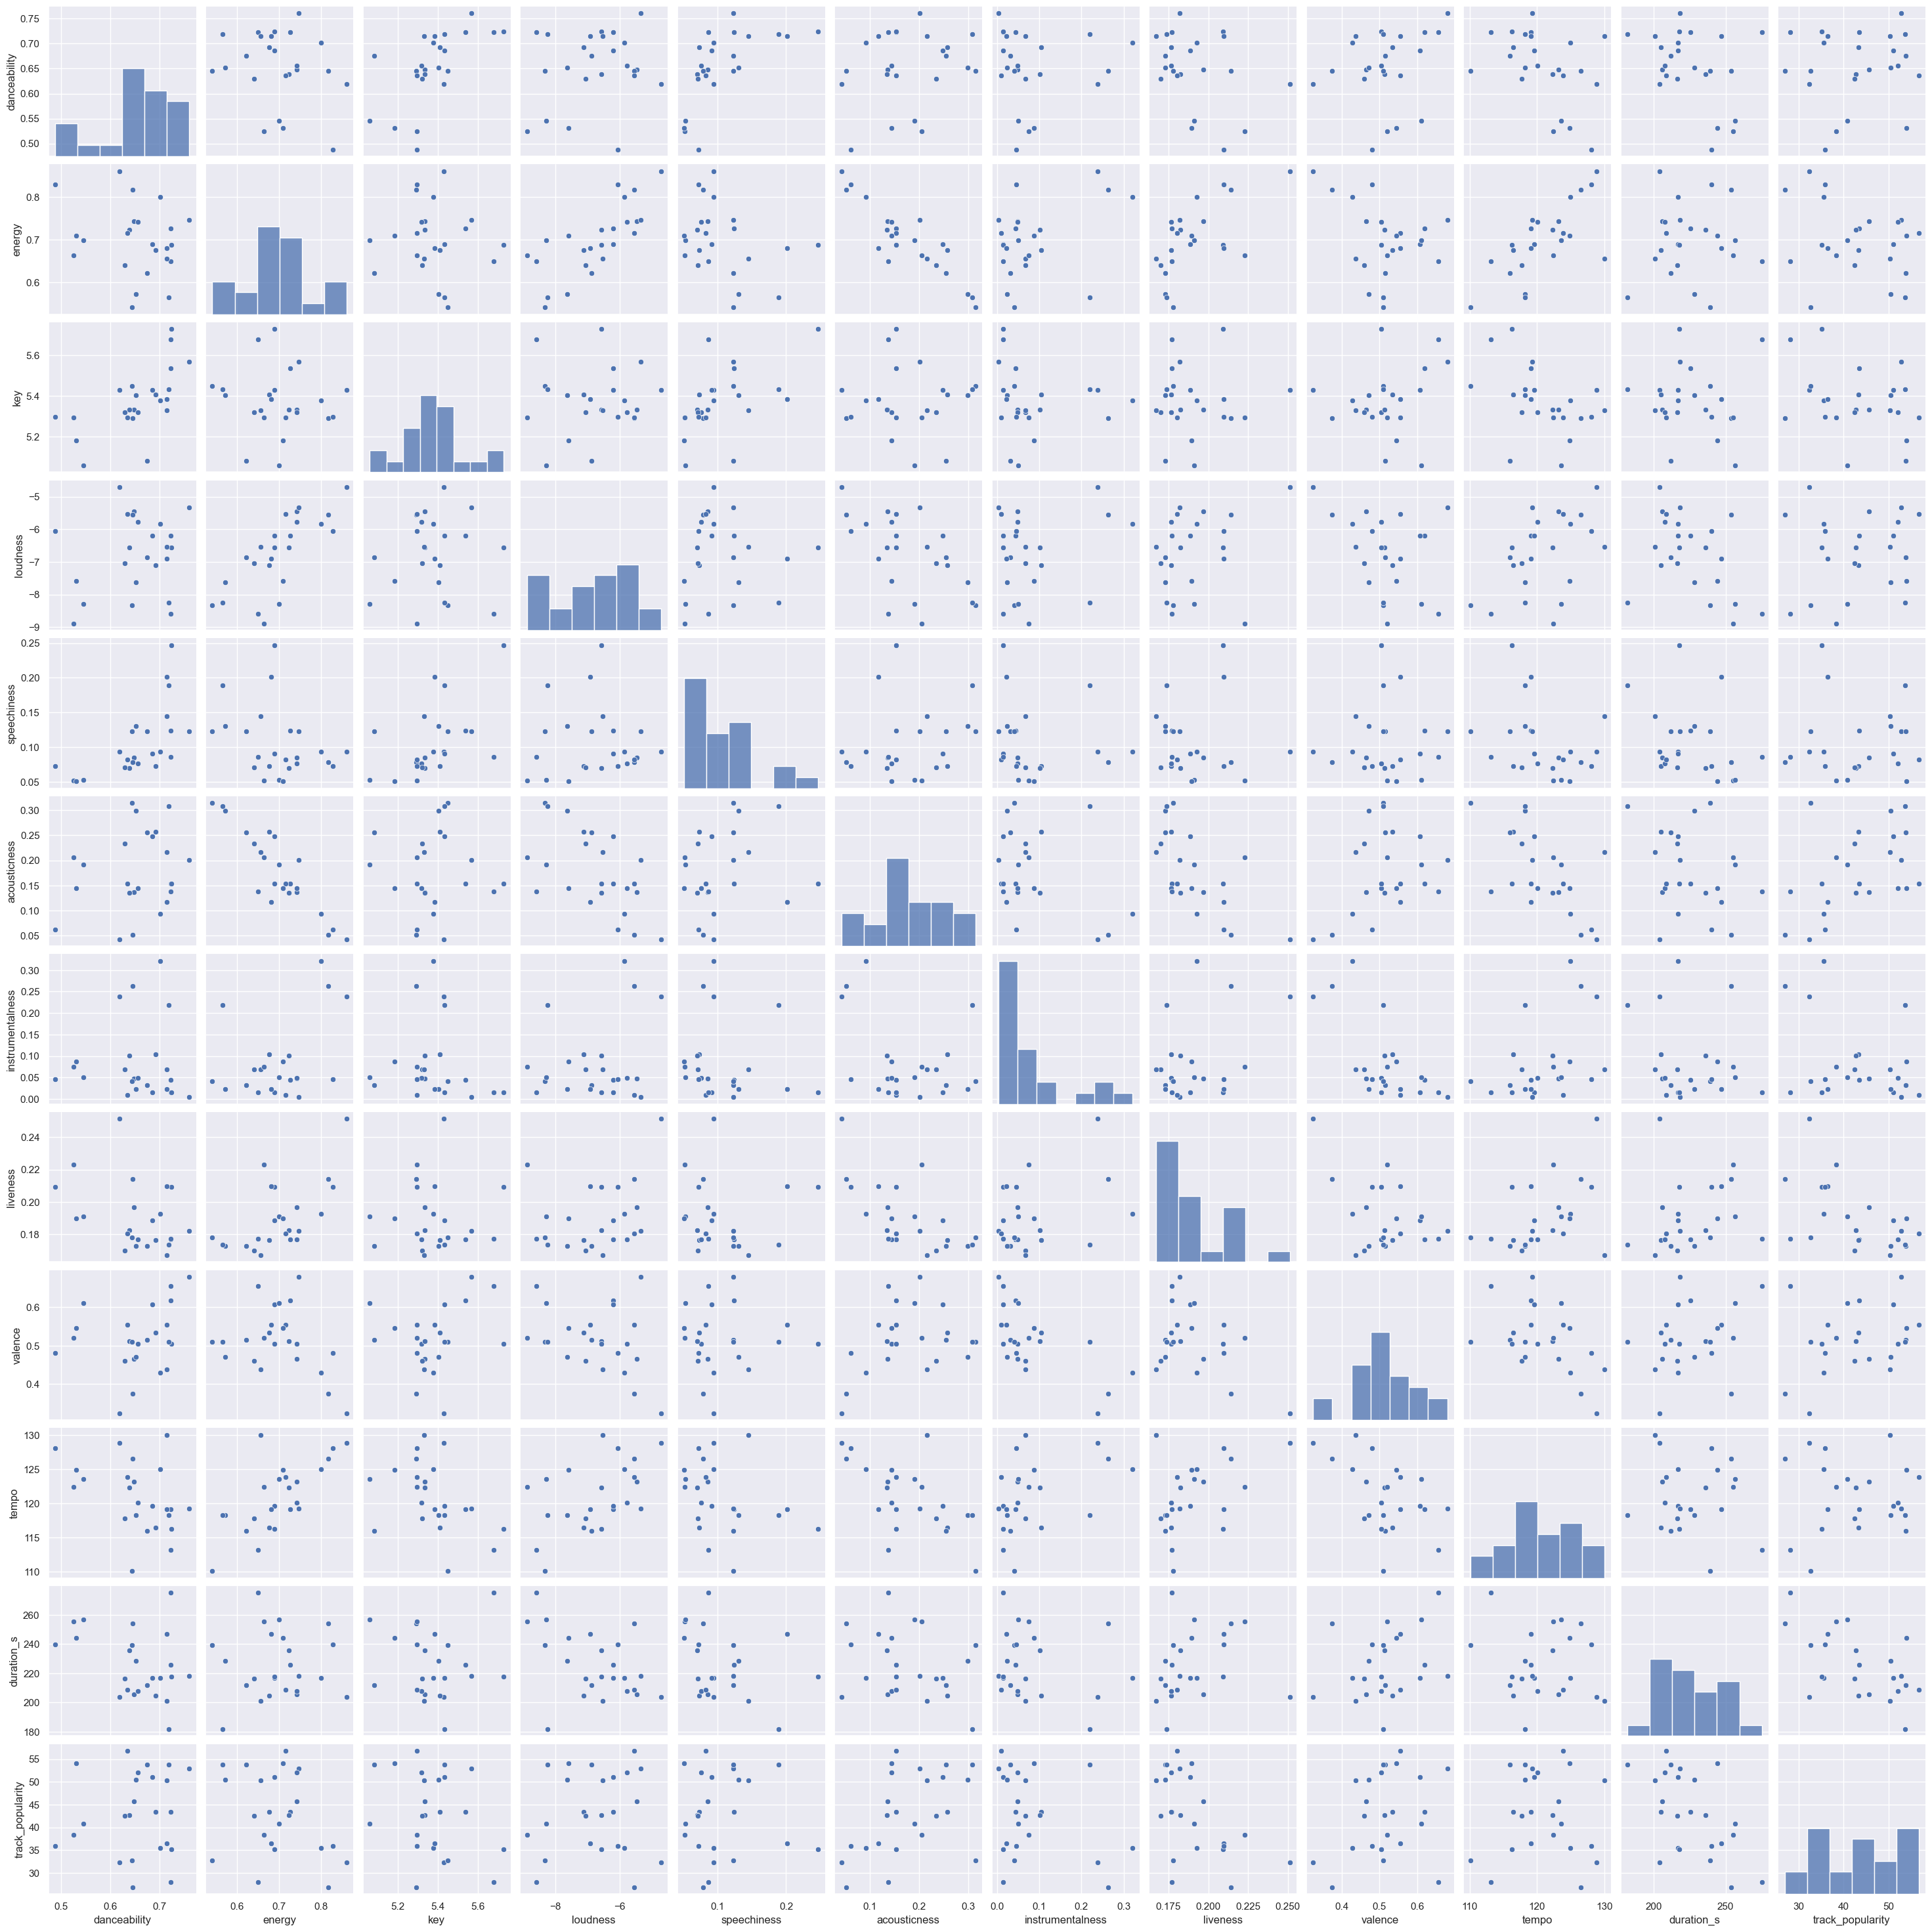

In [156]:
sns.pairplot(data = subgenre_pivot_mean[sound_index_cols + pop_index])

* Means of track popularity correlates by subgenres correlate to its representatives of duration(s), liveness negatively and acousticness positively.  

In [157]:
# double check with median
indexs_corr_median = subgenre_pivot_median[sound_index_cols + pop_index].corr()
indexs_corr_median.loc[indexs_corr_median.index.isin(['duration_s', 'liveness', 'acousticness'])]['track_popularity']

acousticness    0.363256
liveness       -0.426218
duration_s     -0.405312
Name: track_popularity, dtype: float64

## 3. Findings Summary

* Almost tracks from dataset released after 2010s.
* Most track popularity scores are around 40-60; 9% of dataset got 0 score of popularity.
* A playlist collects 73 songs and has 35 scores of popularity, averagely.  
* EDM has most number of playlists and tracks as well, but the popularity score is lowest. Latin and Pop get highest popularity index.
* Subgenres having top highest popularity score mostly contain "pop" as a part.
* About sound indicators:
    * Pairs of "Energy vs. Loudness" and "Valence vs. Danceability" correlate positively; pairs of "Energy vs. Acousticness" and "Loudness vs. Acousticness" correlate negatively.
    * Rap's songs lead to have fastest speech, while rock's seems the lowest. Danceability of rock is also significantly lower than rest of genres. However, rock's songs have longest duration (around 4 minutes 10 seconds).
    * Energy of R&B is weakest than other genres.
    * Songs belonging EDM got mostly low acousticness and valence scores, but higher instrumentalness.
    * None of indicators significantly correlates to popularity score. However, when select mean values representing for subgenre, means of track popularity correlate with mean of duration(s), liveness negatively and acousticness positively. 